I. Data Engineering</br>
1. Data discovery</br>
2. Data cleanup</br>
II. Exploratory Data Analysis</br>
1. Data distributions</br>
2. Rented Bike Count Fluctuations Across the Year</br>
3. Data correlations </br>
III. Machine learning </br>
1. Feature Engineering </br>
2. Model </br>



In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from functools import partial
from IPython.core.display import display, HTML

display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

# Data Engineering

## Data discovery

In [116]:
#inspecting column names and data types;
bikes_df = pd.read_csv('SeoulBikeData.csv')
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [117]:
#showing first 5 rows of data
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


There are no missing values in any of the columns. Some Object data types can be adjusted for easier handling, e.g. "Date" changed into a Datetime object, "Holiday" and "Functioning Day" changed into Boolean after confirming they hold two unique values.

In [118]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [119]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [120]:
#summary of the dataset
bikes_df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [121]:
bikes_df.Date.loc[0]

'01/12/2017'

In [122]:
bikes_df.Date.loc[len(bikes_df)-1]

'30/11/2018'

The dataset includes rented bike counts from Dec 1st. 2017 to Nov. 30th 2018. The data is provided for every hour of the day, along with weather information including Temperature, Humidity, Wind Speed and Rainfall. It also describes the Season of the year for every entry and indicates whether it was a holiday or not. The bike renting service was not always available, which is described by the Functioning Day column.

The dataset consists of 8760 entries in total. The mean bike count rent is 705 rents per hour, while the median amounts to 505 rents. This difference is most likely linked to outliers with unusually high counts of bike rents. This is further reinforced by checking the min/max values for the rented bike count, which are 0 and 3556 respectively - the latter number being an example of the outlier.

The average year temperature amounts to 12.9 degrees Celsius with a median of 13.7.

An interesting observation can be made with Rainfall and Snowfall features - while they have a relatively low mean values (1.1 mm and 0.4 mm respectively), their median values are both at 0. This essentially means that over 50% of days there were no rain- or snowfalls. With that in mind, it stands to question whether these features shouldn't be boolean and signify whether it was raining or not during the given hour of a day. This might simplify any models built within this exercise without affecting their accuracy.

## Data Cleanup

Since both Holiday and Functioning Day features include only 2 unique values each, turning their data type into boolean will make further data processing more efficient. The Date feature will be turned a proper Datetime type along the way.

In [123]:
#changing Date feature into Datetime
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")

#changing Holiday feature into Boolean
bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
bikes_df.loc[bikes_df['Holiday'] == 'No Holiday', 'Holiday'] = 0
bikes_df['Holiday'] = bikes_df['Holiday'].astype(bool, copy=False)

#changing Functioning Day feature into Boolean
bikes_df.loc[bikes_df['Functioning Day'] == 'No', 'Functioning Day'] = 0
bikes_df.loc[bikes_df['Functioning Day'] == 'Yes', 'Functioning Day'] = 1
bikes_df['Functioning Day'] = bikes_df['Functioning Day'].astype(bool, copy=False)

bikes_df.rename(inplace=True, columns={'Temperature(C)': 'Temperature', 'Rented Bike Count':'RentedBikeCount'})

#checking the data types after changes
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   RentedBikeCount           8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature               8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   object        
 12  Holiday             

# Exploratory Data Analysis

## Data distributions

To get a visual idea of the data distributions, we plotted histograms, violin plots and bar plots below for all features except for the Date, Hour, Month, Holiday and Functioning Day features.

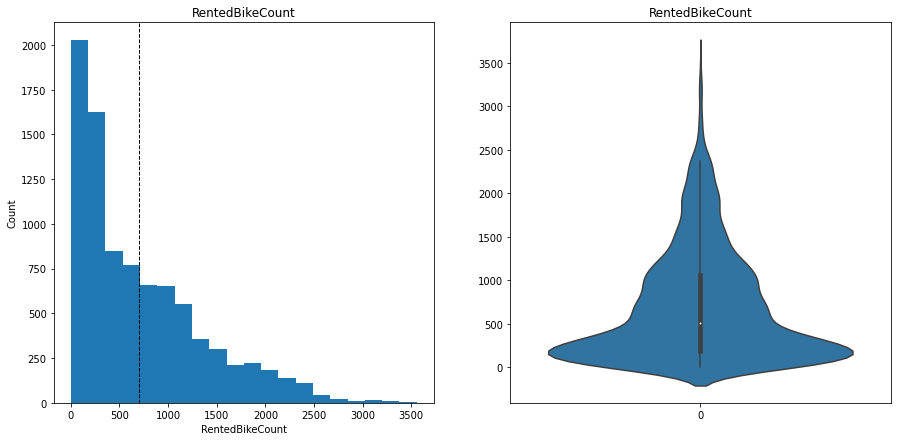

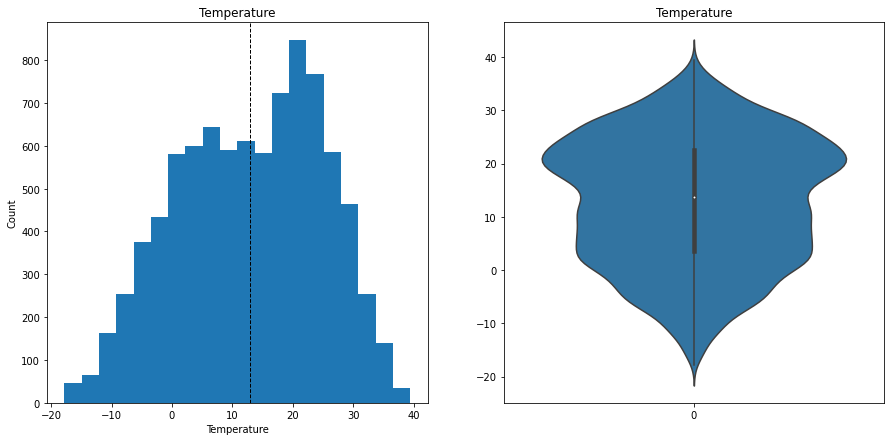

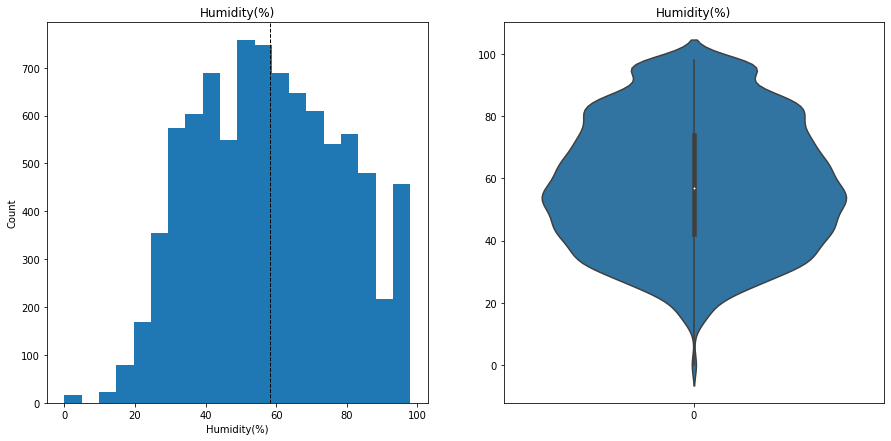

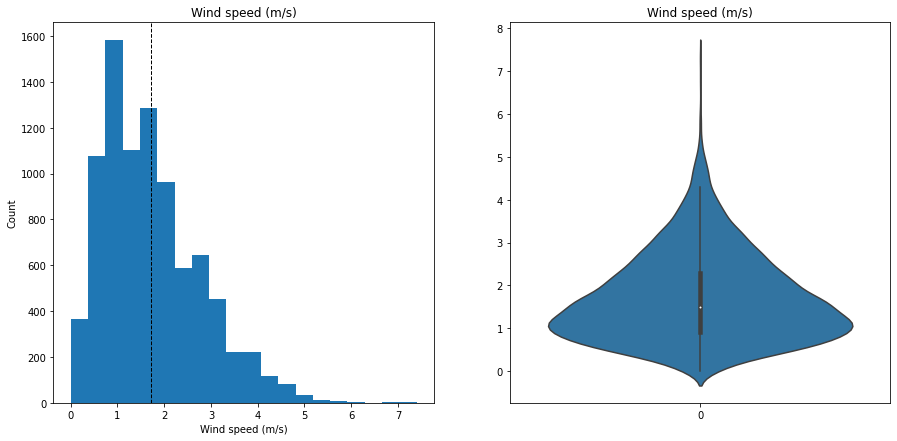

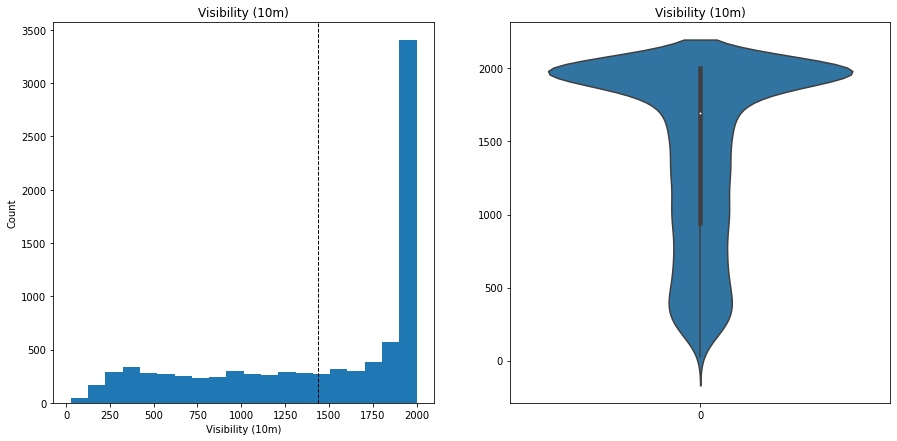

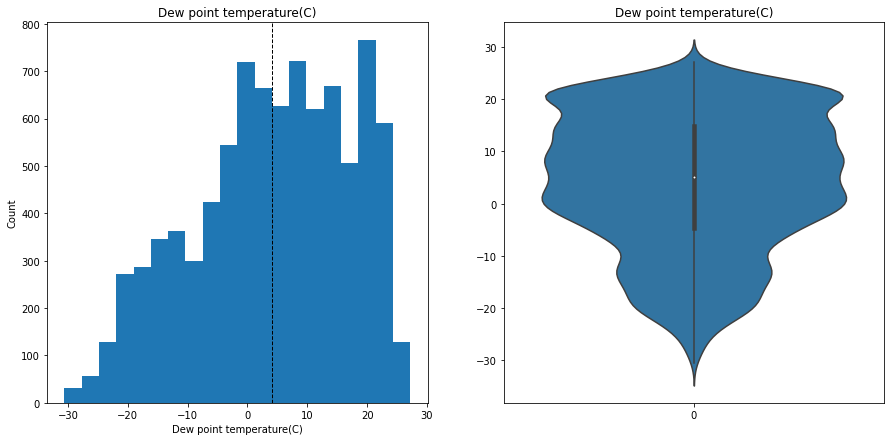

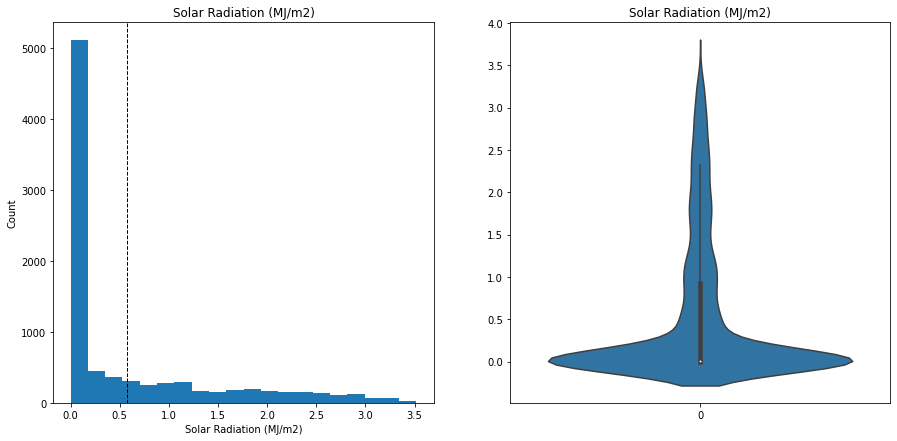

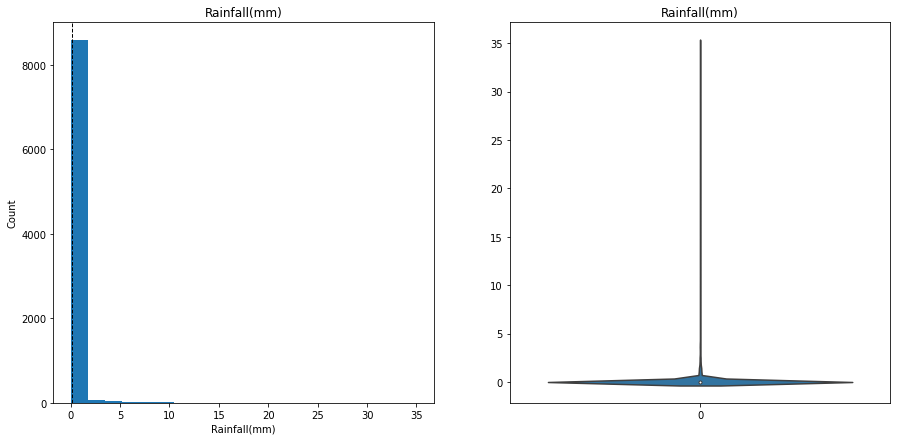

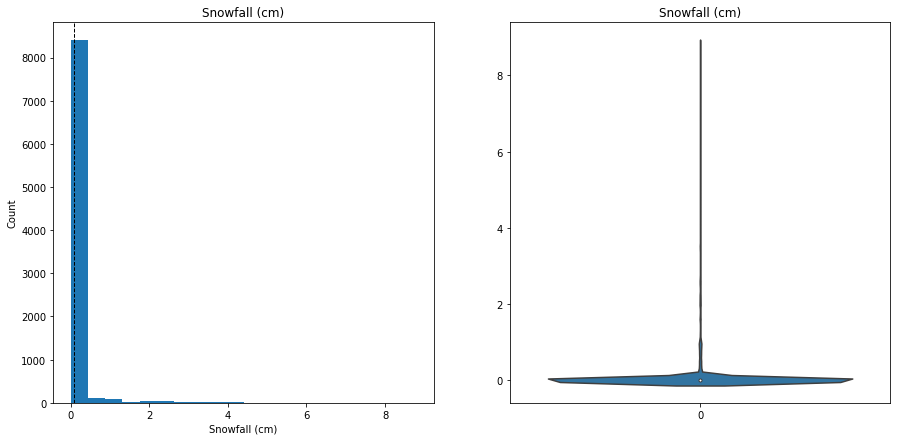

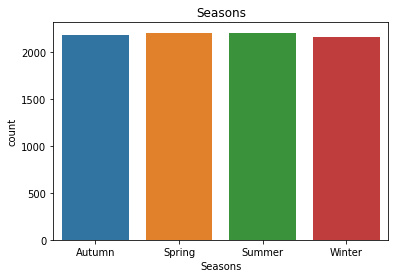

In [124]:
for i in bikes_df.columns:
    if i in ['Date', 'Hour', 'Month'] or bikes_df[i].dtype == 'bool':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,2,1)
        plt.figure
        plt.hist(bikes_df[i], bins=20)
        plt.axvline(bikes_df[i].mean(), color='k', linestyle='dashed', linewidth=1)
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        ax = plt.subplot(1,2,2)
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Rented bike count is right skewed and far from a normal distribution, as the values are concentrated around lower numbers of bike rents. The mean bike count rent per hour is around 700, while the median per hour bike rent count is around 500.<br />
Temperature is much closer to a normal distribution, although it is slightly left skewed. The mean temperature amounts to around 13 degrees Celsius, while the median is slightly higher at around 14 degrees. It is worth noting that Dew Point temperature appears to be distributed in a much similar fashion to Temperature, implying a close correlation.<br />
Humidity is normally distributed with mean humidity at 58% and the median at 57%.<br />
Wind speed, rainfall, snowfall and solar radiation are heavily right skewed, which is expected, as the high values can go to large extremes and form a long tail of outliers on the graphs. Similarly to the Visibity feature except that it is heaily left skewed.<br />
Seasons box plot is expected to show almost equal counts for all the seasons. The neglibigle differences coming from the fact that the seasons do not share the exact same number of days.




In [125]:
rent_season_group = bikes_df[['Seasons','Holiday']].groupby(['Seasons']).apply(lambda x: x['Holiday'].count() / 24).reset_index()
rent_season_group.rename(inplace=True, columns={0:'Days'})
rent_season_group

,Seasons,Days
0,Autumn,91.0
1,Spring,92.0
2,Summer,92.0
3,Winter,90.0


The rented bike count histogram presented the data as is, i.e. displayed the counts for every hour throughout the year. Let's agggregate the same data on a per day basis, to get an overview of counts distribution for entire days.

In [126]:
rent_day_group = bikes_df[['Date', 'RentedBikeCount']].groupby(['Date']).sum()

rent_day_group['RentedBikeCount']
rent_day_group.max()
rent_day_group.head()

,RentedBikeCount
Date,
2017-12-01,9539
2017-12-02,8523
2017-12-03,7222
2017-12-04,8729
2017-12-05,8307


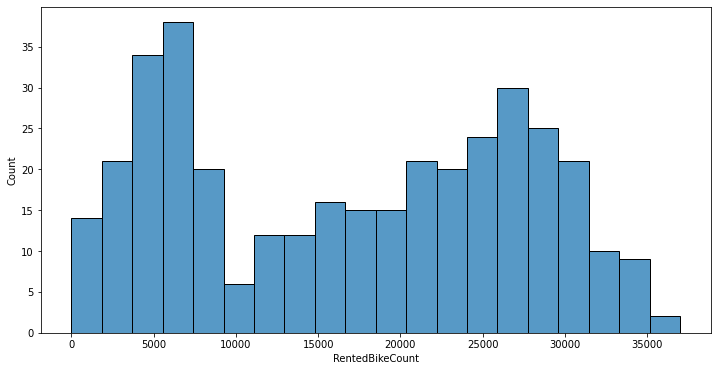

In [127]:
plt.figure(figsize=(12,6))
sns.histplot(data=rent_day_group, x='RentedBikeCount',bins=20, binrange=(0,37000))
plt.show()

The histogram has a significantly different shape then the one created for per hour bike counts. Let's see whether the shape is correlated with bike rent counts for different seasons.

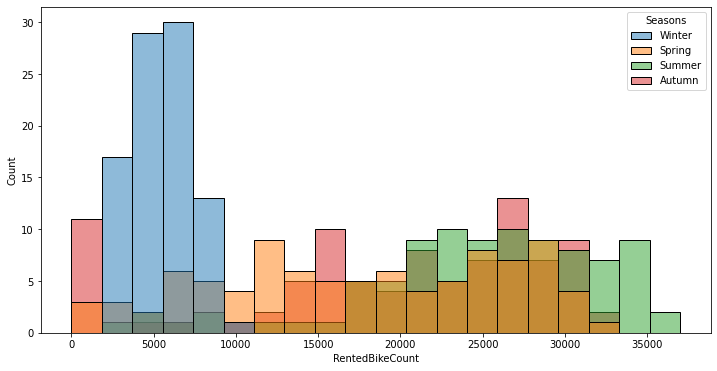

<Figure size 432x288 with 0 Axes>

In [128]:

rent_season_group = bikes_df[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
plt.figure(figsize=(12,6))
sns.histplot(data=rent_season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()


It is interesting to note that the shape of the histogram changed significantly for most of the bins except for the 0-1000 range which appears largely unchanged. This range is dominated by Winter readings and that is why when doing a distribution per Season, this block is almost the same as for the per day distribution. We should expect the remaining of the year to regain its previous shape, when we treat the remaining seasons (spring, summer and autumn) as one.

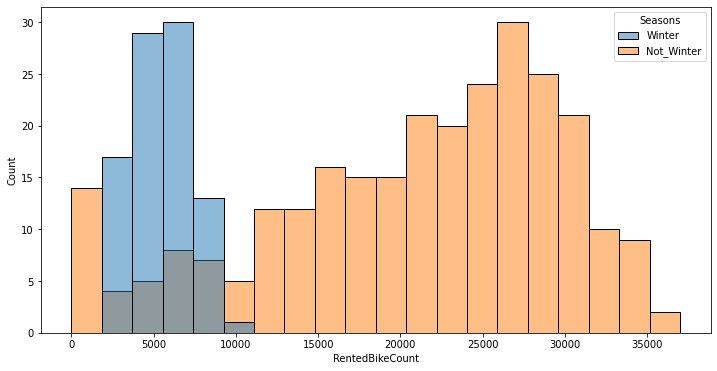

<Figure size 432x288 with 0 Axes>

In [129]:
rent_2season_group = pd.DataFrame(rent_season_group.reset_index())
#bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
rent_2season_group.loc[rent_2season_group['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'
plt.figure(figsize=(12,6))
sns.histplot(data=rent_2season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()


To understand the data better we might want to exclude the days where the service was not functioning and see the data distribution again:


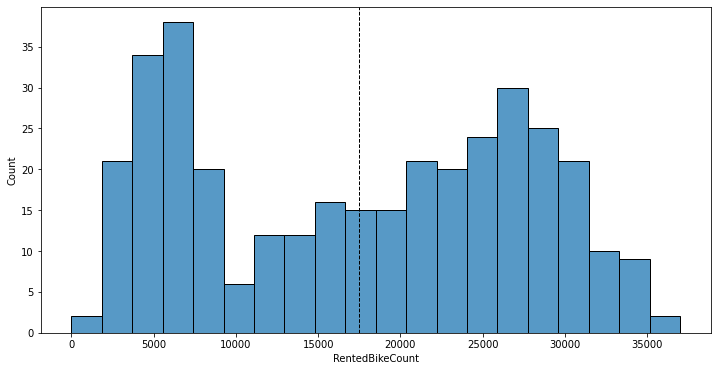

<Figure size 432x288 with 0 Axes>

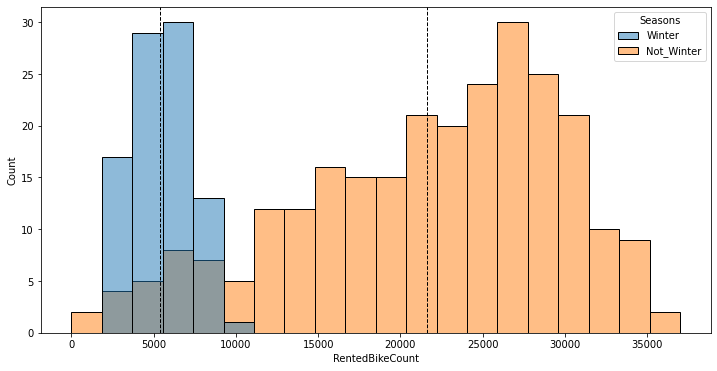

<Figure size 432x288 with 0 Axes>

In [130]:
bikes_df_only_functioning = bikes_df[bikes_df['Functioning Day'] == True]
rent_day_group_only_functioning = bikes_df_only_functioning[['Date', 'RentedBikeCount']].groupby(['Date']).sum()
plt.figure(figsize=(12,6))
sns.histplot(data=rent_day_group_only_functioning, x='RentedBikeCount',bins=20,binrange=(0,37000))
plt.axvline(rent_day_group_only_functioning['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()
plt.clf()
rent_season_group_only_functioning = bikes_df_only_functioning[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
rent_2season_group_only_functioning = pd.DataFrame(rent_season_group_only_functioning.reset_index())
rent_2season_group_only_functioning.loc[rent_2season_group_only_functioning['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'
plt.figure(figsize=(12,6))
sns.histplot(data=rent_2season_group_only_functioning, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.axvline(rent_2season_group_only_functioning[rent_2season_group_only_functioning['Seasons'] == 'Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(rent_2season_group_only_functioning[rent_2season_group_only_functioning['Seasons'] == 'Not_Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.clf()



The bike rent count distribution is apparently significantly different in Winter than in other months of the year.


## Rented Bike Count Fluctuations Across the Year

To get an overview of the bike renting service, we created a few plots below to demonstrate the trends across different months and their possible link with temperatures and rainfalls.

In [131]:
#creating the "Month" column
bikes_df['Month'] = pd.DatetimeIndex(bikes_df['Date']).month
months_names =['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_nums = range(12)
def month_insert(x):
    return months_names[x-1]
bikes_df['Month'] = bikes_df['Month'].apply(month_insert)
bikes_df['Month']

0       Dec
1       Dec
2       Dec
3       Dec
4       Dec
       ... 
8755    Nov
8756    Nov
8757    Nov
8758    Nov
8759    Nov
Name: Month, Length: 8760, dtype: object

   Month  RentedBikeCount
0    Dec           185330
1    Jan           150006
2    Feb           151833
3    Mar           380594
4    Apr           524227
5    May           707088
6    Jun           896887
7    Jul           734460
8    Aug           651887
9    Sep           673612
10   Oct           650675
11   Nov           465715


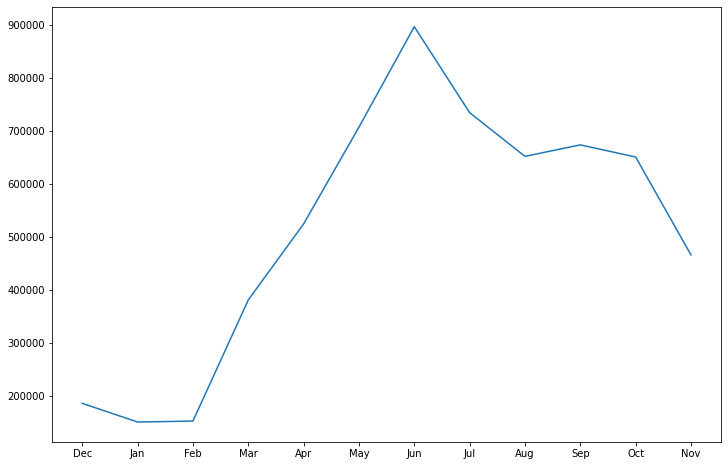

In [132]:
rent_month_group = bikes_df[['Month','RentedBikeCount']].groupby(['Month'], sort=False).sum().reset_index()
print(rent_month_group)
plt.figure(figsize=(12,8))
plt.plot(rent_month_group['Month'], rent_month_group['RentedBikeCount'])
#plt.axis([1,12, 120000, 950000])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))

plt.show()

The total number of bike rents is the lowest in December, January and February and peaks in June. This appears to be slightly correlated by rainfall (note how the rainfall was relatively low in June compared to May and July, August) and closely correlated with the mean month temperature (see plots below).

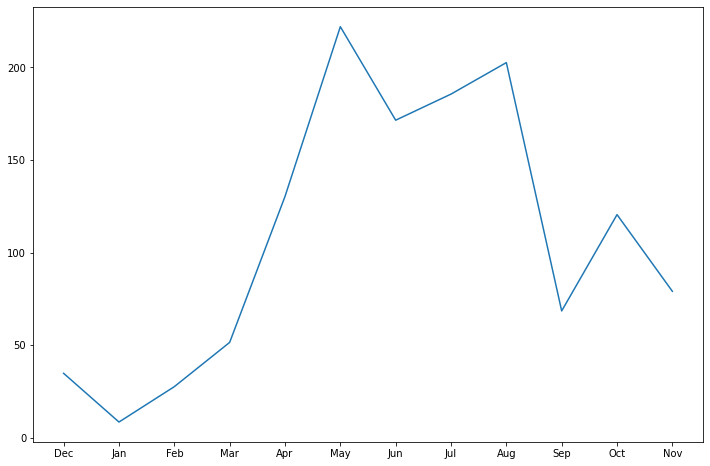

In [133]:
rainfall_month_group = bikes_df[['Month','Rainfall(mm)']].groupby(['Month'], sort=False).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rainfall_month_group['Month'], rainfall_month_group['Rainfall(mm)'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))

plt.show()


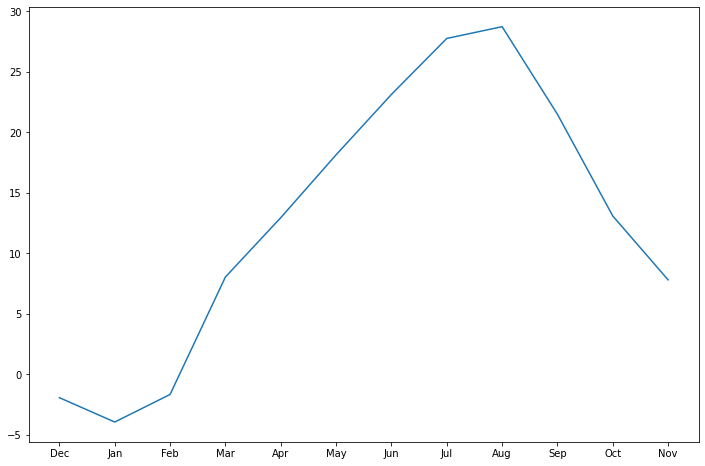

In [134]:
temperature_month_group = bikes_df[['Month','Temperature']].groupby(['Month'],sort=False).mean().reset_index()
plt.figure(figsize=(12,8))
plt.plot(temperature_month_group['Month'], temperature_month_group['Temperature'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.show()

With a relatively good understanding of the data at hand, we may proceed to analyze data correlations and see if our initial conclusions are backed by data science.

## DATA CORRELATIONS

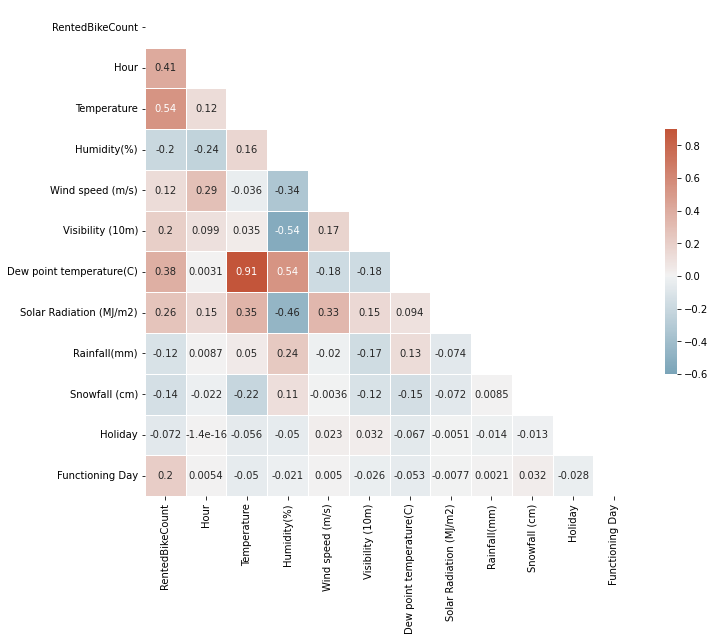

In [135]:
bikes_corr = bikes_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(bikes_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bikes_corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [136]:
frequency_table = pd.crosstab(bikes_df['Holiday'], bikes_df['Functioning Day'])
print(frequency_table)

Functioning Day  False  True
Holiday                     
False              271  8057
True                24   408


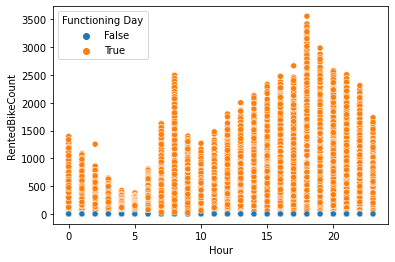

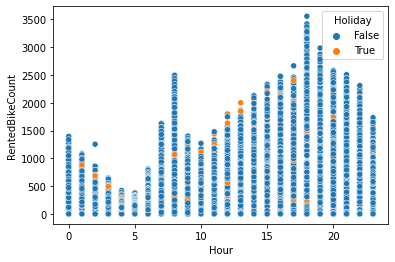

<Figure size 432x288 with 0 Axes>

In [137]:
#plt.scatter(data=bikes_df, x='Hour', y='RentedBikeCount', alpha=0.04, hue='Functioning Day')
sns.scatterplot(y = 'RentedBikeCount', x = 'Hour', data = bikes_df, hue = 'Functioning Day')
plt.show()
plt.clf()
sns.scatterplot(y = 'RentedBikeCount', x = 'Hour', data = bikes_df, hue = 'Holiday')
plt.show()
plt.clf()

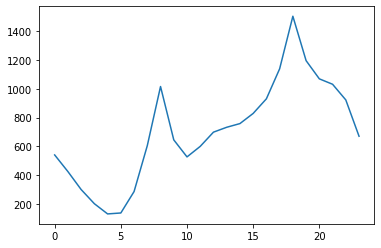

In [138]:
grouping = bikes_df[['Hour','RentedBikeCount']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['RentedBikeCount'])
plt.show()

In [139]:
bikes_df['Hour'] = bikes_df['Hour'].astype(object)

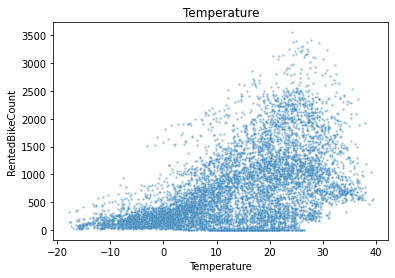

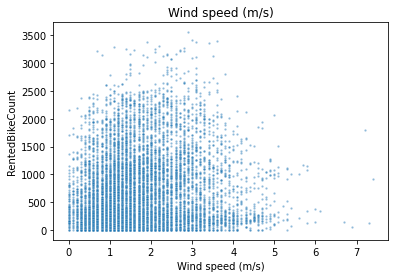

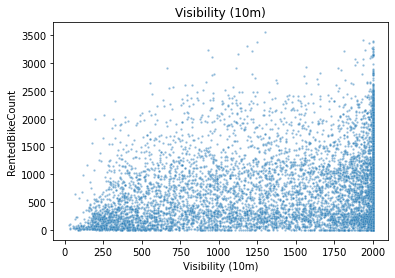

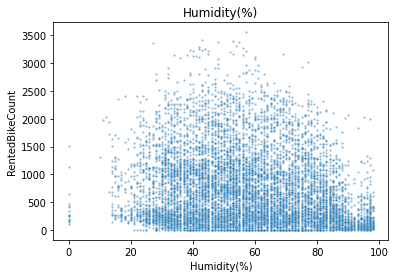

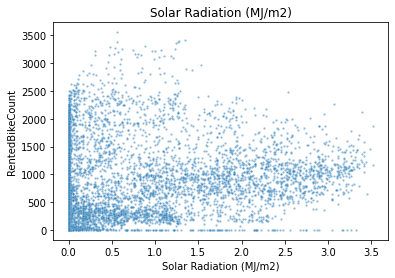

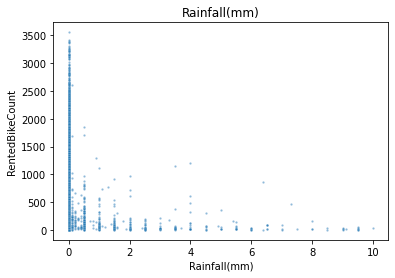

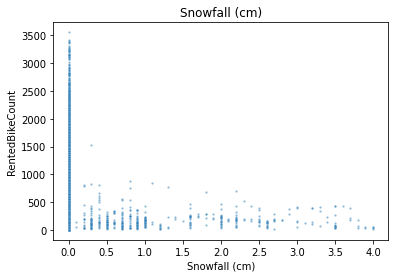

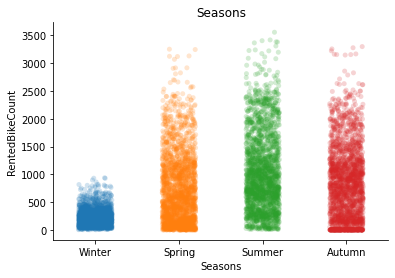

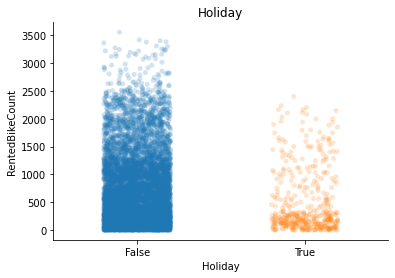

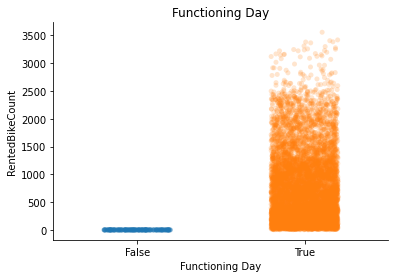

<Figure size 432x288 with 0 Axes>

In [140]:

sns.scatterplot(x=bikes_df['Temperature'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Temperature')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Wind speed (m/s)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Wind speed (m/s)')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Visibility (10m)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Visibility (10m)')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Humidity(%)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Humidity(%)')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Solar Radiation (MJ/m2)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Solar Radiation (MJ/m2)')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Rainfall(mm)'][bikes_df['Rainfall(mm)'] <= 10], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Rainfall(mm)')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Snowfall (cm)'][bikes_df['Snowfall (cm)'] <= 4], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Snowfall (cm)')
plt.show()
plt.clf()

sns.stripplot(x='Seasons', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Seasons')
plt.show()
plt.clf()

sns.stripplot(x='Holiday', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Holiday')
plt.show()
plt.clf()

sns.stripplot(x='Functioning Day', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Functioning Day')
plt.show()
plt.clf()

# Machine Learning

## Feature Engineering

In [141]:
# # as shown in data distributions, we can bin the Seasons data into two categories: winter and the rest of the year
# bikes_df['IsWinter'] = 1
# bikes_df.loc[bikes_df['Seasons'] != 'Winter', 'IsWinter'] = 0

# dropping the data when the service was not functioning at all, as it would affect the accuracy of the model
bikes_df = bikes_df[bikes_df['Functioning Day'] == True]
bikes_df = bikes_df.drop(columns=['Functioning Day'])

# changing rainfall and snowfall features into one boolean feature: Precipitation
bikes_df['Precipitation'] = 0
bikes_df.loc[bikes_df['Rainfall(mm)'] != 0, 'Precipitation'] = 1
bikes_df.loc[bikes_df['Snowfall (cm)'] != 0, 'Precipitation'] = 1

#creating a copy of the dataset
#Snowfall and Rainfall columns are now obsolete due to Precipitation feature
#removing also Seasons and Dew point tempterature as they are correlated to other features (Month and Temperature respectively)
bikes_df_testing = bikes_df.drop(columns=['Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Dew point temperature(C)'])

In [142]:
bikes_df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     8465 non-null   datetime64[ns]
 1   RentedBikeCount          8465 non-null   int64         
 2   Hour                     8465 non-null   object        
 3   Temperature              8465 non-null   float64       
 4   Humidity(%)              8465 non-null   int64         
 5   Wind speed (m/s)         8465 non-null   float64       
 6   Visibility (10m)         8465 non-null   int64         
 7   Solar Radiation (MJ/m2)  8465 non-null   float64       
 8   Holiday                  8465 non-null   bool          
 9   Month                    8465 non-null   object        
 10  Precipitation            8465 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 735.7+ KB


In [143]:

le = LabelEncoder()
features = bikes_df_testing.drop(columns = ['RentedBikeCount', 'Date'])
features['Hour'] = le.fit_transform(features['Hour'])
features['Month'] = le.fit_transform(features['Month'])
features['Holiday'] = le.fit_transform(features['Holiday'])
features['Precipitation'] = le.fit_transform(features['Precipitation'])
Y = bikes_df_testing['RentedBikeCount']


In [144]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hour                     8465 non-null   int32  
 1   Temperature              8465 non-null   float64
 2   Humidity(%)              8465 non-null   int64  
 3   Wind speed (m/s)         8465 non-null   float64
 4   Visibility (10m)         8465 non-null   int64  
 5   Solar Radiation (MJ/m2)  8465 non-null   float64
 6   Holiday                  8465 non-null   int64  
 7   Month                    8465 non-null   int32  
 8   Precipitation            8465 non-null   int64  
dtypes: float64(3), int32(2), int64(4)
memory usage: 595.2 KB


In [145]:
print(mutual_info_regression(features, Y, random_state=68, discrete_features=[0,6,7,8]))

[0.3709755  0.37822327 0.10833162 0.01572221 0.05565448 0.18976532
 0.00691936 0.28859064 0.0990408 ]


In [146]:
score_func = partial(mutual_info_regression, discrete_features=[0,6,7,8], random_state=68)

# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=4)

selection.fit_transform(features, Y)
features = features[features.columns[selection.get_support(indices=True)]]

features.head()

,Hour,Temperature,Solar Radiation (MJ/m2),Month
0,0,-5.2,0.0,2
1,1,-5.5,0.0,2
2,2,-6.0,0.0,2
3,3,-6.2,0.0,2
4,4,-6.0,0.0,2


Using filter methods for feature selection, we selected the following four features for the model: Hour, Temperature, Month and Solar Radiation.

In [147]:
#creating one-hot-encoded data for categorical data
hours_ohe = pd.get_dummies(bikes_df_testing.Hour, drop_first=True, prefix='h_')
months_ohe = pd.get_dummies(bikes_df_testing.Month, drop_first=True)
bikes_df_testing = bikes_df_testing.join(hours_ohe)
bikes_df_testing = bikes_df_testing.join(months_ohe)
print(bikes_df_testing.columns)


Index(['Date', 'RentedBikeCount', 'Hour', 'Temperature', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',
       'Holiday', 'Month', 'Precipitation', 'h__1', 'h__2', 'h__3', 'h__4',
       'h__5', 'h__6', 'h__7', 'h__8', 'h__9', 'h__10', 'h__11', 'h__12',
       'h__13', 'h__14', 'h__15', 'h__16', 'h__17', 'h__18', 'h__19', 'h__20',
       'h__21', 'h__22', 'h__23', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')


C:\Users\Rogo\miniconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [150]:
bikes_df_testing.drop(columns=['Date','Month','Hour'],inplace=True)
bikes_df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RentedBikeCount          8465 non-null   int64  
 1   Temperature              8465 non-null   float64
 2   Humidity(%)              8465 non-null   int64  
 3   Wind speed (m/s)         8465 non-null   float64
 4   Visibility (10m)         8465 non-null   int64  
 5   Solar Radiation (MJ/m2)  8465 non-null   float64
 6   Holiday                  8465 non-null   bool   
 7   Precipitation            8465 non-null   int64  
 8   h__1                     8465 non-null   uint8  
 9   h__2                     8465 non-null   uint8  
 10  h__3                     8465 non-null   uint8  
 11  h__4                     8465 non-null   uint8  
 12  h__5                     8465 non-null   uint8  
 13  h__6                     8465 non-null   uint8  
 14  h__7                    

In [151]:
features = bikes_df_testing.drop(columns=['RentedBikeCount'])


[0.37728449 0.10935479 0.01923597 0.05454687 0.19571427 0.18796781
 0.0973136  0.19788324 0.00359399 0.01933693 0.00878041 0.02323452
 0.04688758 0.03643148 0.02106148 0.00918253 0.01628398 0.01368016
 0.01054901 0.01573928 0.01688061 0.00708943 0.00832423 0.
 0.00569832 0.01272232 0.03266171 0.01093867 0.01267996 0.00806743
 0.01215703 0.01018339 0.01804434 0.04695952 0.04792866 0.06788948
 0.01656832 0.04120338 0.0158534  0.01260521 0.00857216 0.02438938
 0.02027102]


In [152]:
scaler = StandardScaler()
scaled = scaler.fit(features)
X = scaled.transform(features)

## Model


LR assumptions: https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html
Linearity: The relationship between X and the mean of Y is linear.
Homoscedasticity: The variance of residual is the same for any value of X.
Independence: Observations are independent of each other.
Normality: For any fixed value of X, Y is normally distributed.

In [153]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=6)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)
print(len(x_train))
print(len(x_test))
print(len(x_val))


5417
1693
1355


In [154]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

('0', '1', '3', '6', '9', '10', '11', '13', '14', '23', '24', '25', '26', '27', '28', '30', '32', '34', '36', '39')
-134313.181813164


C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


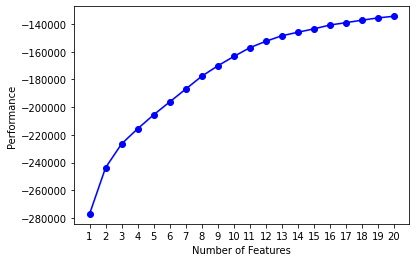

In [164]:
lr = LinearRegression()
sfs = SFS(lr,
          k_features=20,
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=0)
sfs.fit(x_train, y_train)

# Print the chosen feature names
print(sfs.subsets_[20]['feature_names'])
# Print the accuracy of the model after sequential forward selection
print(sfs.subsets_[20]['avg_score'])
# Plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.show()

train score:
0.6965073301142042
test score:
0.6972357815192429


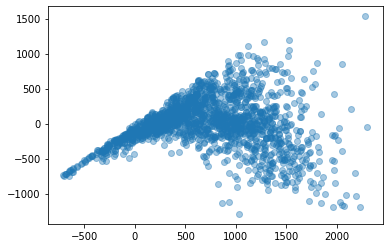

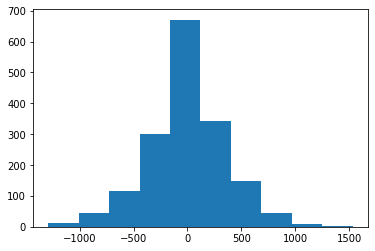

In [200]:

mlr = LinearRegression()

mlr.fit(x_train, y_train)

y_predict = mlr.predict(x_test)

# Input code here:
print('train score:')
print(mlr.score(x_train, y_train))
print('test score:')
print(mlr.score(x_test, y_test))

residuals = y_predict - y_test
plt.scatter(y_predict, residuals, alpha=0.4)
plt.show()
plt.clf()
plt.hist(residuals)
plt.show()

In [110]:
coeff = list(mlr.coef_.flat)

feature_coeff = np.vstack((features,coeff))

feature_df = pd.DataFrame(feature_coeff)
feature_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,0,0,0
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,False,1,...,1,0,0,0,0,0,0,0,0,0
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,0,0,0
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,0,0,0
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,False,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,False,0,...,0,0,0,0,0,0,0,1,0,0
8462,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,False,0,...,0,0,0,0,0,0,0,1,0,0
8463,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,False,0,...,0,0,0,0,0,0,0,1,0,0
8464,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,False,0,...,0,0,0,0,0,0,0,1,0,0


train score:
0.9887246680654331
test score:
0.7650113846942782
21


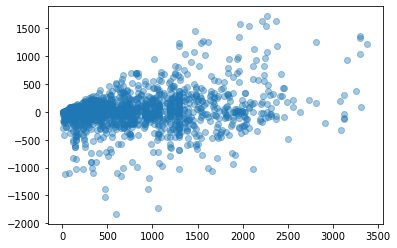

In [201]:
dt = DecisionTreeRegressor(max_depth = 21, ccp_alpha=0.01)
dt.fit(x_train, y_train)
y_predict = dt.predict(x_test)
print('train score:')
print(dt.score(x_train, y_train))
print('test score:')
print(dt.score(x_test, y_test))
print(dt.get_depth())
residuals = y_predict - y_test
plt.scatter(y_predict, residuals, alpha=0.4)
plt.show()

In [ ]:
dt2 = DecisionTreeRegressor(max_depth = 21, ccp_alpha=0.01)
dt2.fit(x_train, y_train)
y_predict = dt2.predict(x_test)
print('train score:')
print(dt2.score(x_train, y_train))
print('test score:')
print(dt2.score(x_test, y_test))
print(dt2.get_depth())
residuals = y_predict - y_test
plt.scatter(y_predict, residuals, alpha=0.4)
plt.show()

# 